In [127]:
import torch
import random
import numpy as np
from PIL import Image
from datasets import load_dataset
from diffusers import AutoencoderKL

In [3]:
vae = AutoencoderKL.from_pretrained('../vae_model')

In [177]:
vae.config

FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 3),
            ('norm_num_groups', 32),
            ('sample_size', 256),
            ('_class_name', 'AutoencoderKL'),
            ('_diffusers_version', '0.4.1'),
            ('_name_or_path', '../vae_model')])

In [8]:
ds = load_dataset('teticio/audio-diffusion-256')

  0%|          | 0/1 [00:00<?, ?it/s]

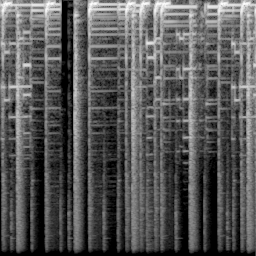

In [166]:
image = random.choice(ds['train'])['image']
image

In [174]:
# encode
input_image = np.frombuffer(image.convert('RGB').tobytes(), dtype="uint8").reshape(
    (image.height, image.width, 3))
input_image = ((input_image / 255) * 2 - 1).transpose(2, 0, 1)
latents = vae.encode(torch.tensor([input_image], dtype=torch.float32)).latent_dist.sample()

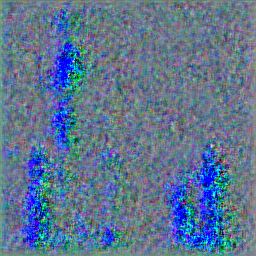

In [176]:
# decode
output_image = vae.decode(latents)['sample']
output_image = torch.clamp(output_image, -1., 1.)
output_image = (output_image + 1.0) / 2.0  # -1,1 -> 0,1; c,h,w
output_image = (output_image.detach().cpu().numpy() *
                255).round().astype("uint8").transpose(0, 2, 3, 1)[0]
Image.fromarray(output_image)